### Description of the Project

Company XYZ is a Online Travel Agent site, such as Expedia, Booking.com, etc.

You are asked to:

* Create a clean data set where each column is a field in the URL, each row is a given search and the cells are the corresponding URL values. And answer the question: for each search query, how many amenities were selected?

* Create a metric to find the city with the worst search algorithm.

### 1. Read Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
s = "http://www.mysearchforhotels.com/shop/hotelsearch?"
lst = []
with open("../dataset/url_list.txt") as f:
    for line in f:
        res = line.replace(s, "").replace("\n","").split("&")
        d = {item.split("=")[0][6:]: item.split("=")[1] for item in res}
        lst.append(d)

In [3]:
df = pd.DataFrame(lst)
df["city"] = df.city.str.replace("+", "_").str.split(",").str[0]
df.head()

,checkin,stars_4,min_score,adults,city,checkout,search_page,stars_3,customMaximumPriceFilter,stars_5,freeCancellation,stars_2,children,max_score,couponCode,stars_1,customMinimumPriceFilter,amenities
0,2015-09-19,yes,4,3,New_York,2015-09-20,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-09-14,NaN,4,3,London,2015-09-15,1,yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-09-26,yes,5,2,New_York,2015-09-27,1,NaN,175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-09-02,yes,4,1,Hong_Kong,2015-09-03,1,NaN,NaN,yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-09-20,NaN,5,3,London,2015-09-29,1,NaN,275,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 2. Tasks

#### Task 1. Create a clean data set where each column is a field in the URL, each row is a given search and the cells are the corresponding URL values. And answer the question: for each search query, how many amenities were selected?

In [4]:
df.amenities.notnull().value_counts()

False    76973
True       704
Name: amenities, dtype: int64

704 queries had amenities none null.

In [5]:
df.amenities.value_counts()

internet       272
yes_smoking    170
shuttle        111
yes_pet         90
breakfast       39
lounge          22
Name: amenities, dtype: int64

The above shows only one amenity can be selected in each search query, or just one selected amenity is logged for each search query. This needs technical investigation.

#### Task 2. Create a metric to find the city with the worst search algorithm.

In [6]:
df["search_page"] = df.search_page.astype(int)

In [7]:
cities_cnt = df.groupby("city").apply(lambda df: df.search_page.value_counts()).unstack().sort_index(axis=1)\
.fillna(0).astype(int).T
cities_cnt

city,Hong_Kong,London,New_York,San_Francisco
1,10735,14775,16385,8105
2,766,5258,5329,284
3,168,2876,2779,41
4,62,1833,1728,12
5,27,1245,1143,7
6,13,846,777,0
7,10,570,534,0
8,4,364,372,0
9,1,202,233,0
10,0,89,104,0


In [8]:
adjacent_page_ClickRatio = cities_cnt.apply(lambda s: (s.shift(-1)/s).shift(1) )
adjacent_page_ClickRatio

city,Hong_Kong,London,New_York,San_Francisco
1,NaN,NaN,NaN,NaN
2,0.071355,0.355871,0.325236,0.035040
3,0.219321,0.546976,0.521486,0.144366
4,0.369048,0.637344,0.621806,0.292683
5,0.435484,0.679214,0.661458,0.583333
6,0.481481,0.679518,0.679790,0.000000
7,0.769231,0.673759,0.687259,NaN
8,0.400000,0.638596,0.696629,NaN
9,0.250000,0.554945,0.626344,NaN
10,0.000000,0.440594,0.446352,NaN


Text(0.5, 0, 'Current Search Page')

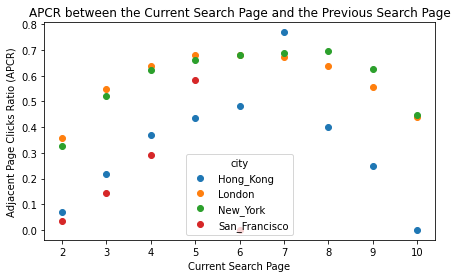

In [10]:
_ = adjacent_page_ClickRatio.plot(style="o", figsize=(7,4))
plt.title("APCR between the Current Search Page and the Previous Search Page")
plt.ylabel("Adjacent Page Clicks Ratio (APCR)")
plt.xlabel("Current Search Page")

The assumption is that if the user find satisfactory content in search page one, the user will not click into search page two. And it may work the same way between search page n and search page n+1 for a couple of additional pages. Beyond that, the user may become frustrated and the search pattern can be more random. Under this theory, the Adjacent Page Clicks Ratio (APCR), defined as (# clicks on Search Page n)/(# clicks on Search Page n-1) can be used to approximate Click Through Rate between adjacent pages at least for the first several search pages.

Now I have calculated the APCR for all available search pages (n=2 to 10) for all available cities. With the APCR for n=2 to 5, I found London and New York consistently take the top two positions, with London being the top. This is a strong indication that London is the city with the worst search algorithm.